In [1]:
import awkward as ak
from coffea import hist, processor
import numpy as np

# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

In [2]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "mumu_mass": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "$m_{\mu\mu}$ [GeV]", 60, 60, 120),
            ),
            "ee_mass": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "$m_{ee}$ [GeV]", 60, 60, 120),
            ),
            "mpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mpt", "$Missing p_{T}$ [GeV]", 60, 60, 240),
            ),
            "mpt_sd": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mpt", "$Missing p_{T}$ [GeV]", 60, 60, 240),
            ),
            "dphi_mpt_z": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("dphi", "$\Delta $phi$", 60, -6.28, 6.28),
            ),
            "dphi_mpt_sd_z": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("dphi", "$\Delta $phi$", 60, -6.28, 6.28),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        gens = ak.zip({
            "pt": events.gen_pt,
            "eta": events.gen_eta,
            "phi": events.gen_phi,
            "mass": events.gen_m,
            "charge": events.gen_id / np.abs(events.gen_id), 
            "id": events.gen_id
        }, with_name="PtEtaPhiMCandidate")
        
        mpt = ak.zip({
            "pt": events.mpt_pt,
            "phi": events.mpt_phi,
            "ptsd": events.mpt_ptsd,
            "phisd": events.mpt_phisd,            
        })

        muons = gens[ np.abs(gens.id) == 13 ]        
        muons_cut = (ak.num(muons) == 2) & (ak.sum(muons.charge) == 0)
        # add first and second muon in every event together
        dimuon = muons[muons_cut][:, 0] + muons[muons_cut][:, 1]

        electrons = gens[ np.abs(gens.id) == 11 ]
        electrons_cut = (ak.num(electrons) == 2) & (ak.sum(electrons.charge) == 0)
        # add first and second electron in every event together
        dielectron = electrons[electrons_cut][:, 0] + electrons[electrons_cut][:, 1]


        dphi_mumu = mpt.phi[muons_cut] - dimuon.phi        
        dphi_mumu = (dphi_mumu + np.pi) % (2 * np.pi) - np.pi
        print(dphi_mumu)
        
        output["sumw"][dataset] += len(events)
        output["mumu_mass"].fill(
            dataset=dataset,
            mass=dimuon.mass,
        )
        
        output["ee_mass"].fill(
            dataset=dataset,
            mass=dielectron.mass,
        )
        
        output["dphi_mpt_z"].fill(
            dataset=dataset,
            dphi=dphi_mumu,
        )
        
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
import time

tstart = time.time()

fileset = {
    'ZJets': [
        'zjets_mpt.root'
    ]
}

output = processor.run_uproot_job(
    fileset,
    treename='T',
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={"workers": 4},
    chunksize=100000,
    maxchunks=None,
)

elapsed = time.time() - tstart
print(output)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

[-3, 2.58, -3.12, 3.09, -2.97, -2.88, ... 3.08, 3.13, -3.02, 3.13, -2.65, -1.43]


/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


{'sumw': defaultdict_accumulator(<class 'float'>, {'ZJets': 10000.0}), 'mumu_mass': <Hist (dataset,mass) instance at 0x7fe7ea2f23d0>, 'ee_mass': <Hist (dataset,mass) instance at 0x7fe7ea2f2d30>, 'mpt': <Hist (dataset,mpt) instance at 0x7fe7ea2f23a0>, 'mpt_sd': <Hist (dataset,mpt) instance at 0x7fe7ea2f2f10>, 'dphi_mpt_z': <Hist (dataset,dphi) instance at 0x7fe7ea2f2d00>, 'dphi_mpt_sd_z': <Hist (dataset,dphi) instance at 0x7fe7ea2f2940>}


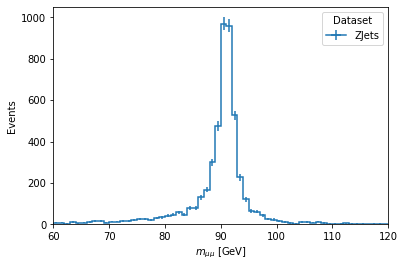

In [4]:
ax = hist.plot1d(output["mumu_mass"], overlay='dataset')

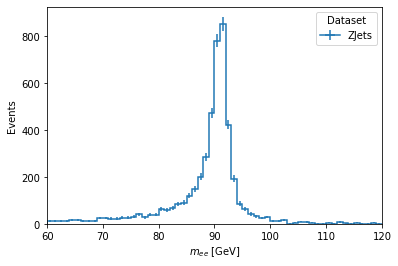

In [5]:
ax = hist.plot1d(output["ee_mass"], overlay='dataset')

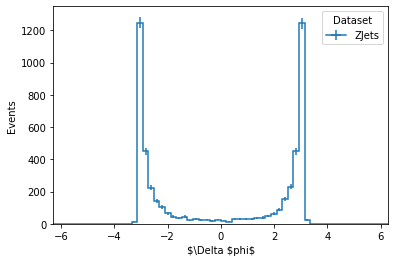

In [6]:
ax = hist.plot1d(output["dphi_mpt_z"], overlay='dataset')